### Model Selection / Validation

In This NoteBook i perform Model Diagnosis on a Regeression Problem and go through the steps of How i Choose My Model and it's Parameters and how i diagnose it for problems of Over and Under Fitting and 

In [28]:
import scipy.io
import numpy as np
from scipy.optimize import minimize,fmin_cg
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

### Data Loading 

- The data Used in This Notebook will help us in solving the following problem which is predicting the amount of water flowing out of a dam using the change of water level in a reservoir

We will begin by visualizing the dataset containing historical records on the change in the water level, $x$, and the amount of water flowing out of the dam, $y$. This dataset is divided into three parts:

- A **training** set that The model will learn on: `X`, `y`
- A **cross validation** set for determining the regularization parameter: `Xval`, `yval`
- A **test** set for evaluating performance. These are “unseen” examples which The model did not see during training: `Xtest`, `ytest`


In [29]:
data = scipy.io.loadmat('data/data')
X,y,Xval,yval,Xtest,ytest = data['X'], data['y'].ravel(),data['Xval'],data['yval'].ravel(),data['Xtest'],data['ytest'].ravel()
m = y.size
theta = np.ones([2,1]).ravel()

### Plotting Data

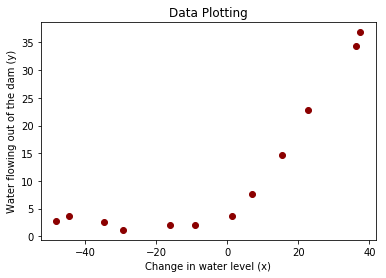

In [30]:
plt.figure()
plt.title('Data Plotting')
plt.scatter(X,y,color='darkred')
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.show()

### Cost Function and Gradient

- Next is Implementation of a Function that Computes Cost J and Gradient of J
- The Cost J is Determined with the following mathmetical formula:

$$ J(\theta) = \frac{1}{2m} \left( \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right)^2 \right) + \frac{\lambda}{2m} \left( \sum_{j=1}^n \theta_j^2 \right)$$

- Where $ h_\theta( x^{(i)})$ repersents our Model Hypothesis (The Model Prediction)

- $\lambda$ is The Regularization Parameter which controls the degree of regularization (thus, help preventing overfitting). The regularization term puts a penalty on the overall cost J. As the magnitudes of the model parameters $\theta_j$ increase, the penalty increases as well

- The Squared Error form of The Cost $ J(\theta) $ is a measure of the average diffrence between the predicted and the actual label

###### Correspondingly, the partial derivative(Gradient) of the cost function for regularized linear regression is defined as:

\begin{align}
& 
& \frac{\partial J(\theta)}{\partial \theta_j} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m} \theta_j & \qquad \text{for } j \ge 1
\end{align}



In [31]:
def CostFunction(X,y,theta,lambda_):
    m = y.size
    J = 0
    grad = np.zeros(theta.shape)
    h = X.dot(theta)
    J = (1/(2*m)) * np.sum(np.square(h-y)) + (lambda_/(2*m)) * np.sum(np.square(theta[1:]))
    
    grad = (1 / m) * (h - y).dot(X)
    
    grad[1:] = grad[1:] + (lambda_ / m) * theta[1:]
    
    return J,grad

In [32]:
J,grad =CostFunction(np.c_[np.ones(m),X],y,theta,1)

In [33]:
print('Cost at inital theta(0.0) = {}'.format(J))
print('Gradients at inital theta(0.0) = {}'.format(grad))

Cost at inital theta(0.0) = 303.9931922202643
Gradients at inital theta(0.0) = [-15.30301567 598.25074417]


### Model Training

In This Section The Function Fit Usess our Former Defintion of Cost $ J(\theta) $ and The Gradient $\frac{\partial J(\theta)}{\partial \theta_j}$ to minimze find the Optimal Parameters $\theta_j$ that minimzes our Cost $ J(\theta) $ to values closer to zero so that the predicted label - the actual label is close to zero thus making an accurate predictions 

Scipy Optimize.Minimze function is Used

In [34]:
def Fit(CostFunction,X,y,lambda_=0.0,maxiter=200):
    initial_theta = np.zeros([X.shape[1]]).ravel()
    costF = lambda p: CostFunction(X,y,p,lambda_)
    options= {'maxiter': maxiter}
    res = minimize(costF,
                        initial_theta,
                        jac=True,
                        method='CG',
                        options=options)
    return res.x

### Training Linear Reg With No Regularzation on the Data

In [35]:
theta = Fit(CostFunction,np.c_[np.ones(m),X],y,0)
theta

array([13.08790351,  0.36777923])

### Linear Fit To the data

After Training our Linear Model we plot The data with The Linear Fit and see how the Linear Fit did on our Data

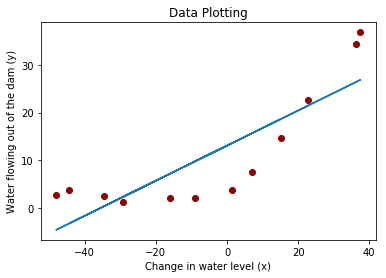

In [36]:
plt.figure()
plt.title('Data Plotting')
plt.scatter(X,y,color='darkred')
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.plot(X,np.c_[np.ones(m),X].dot(theta))

plt.show()

###### As we can see from the plot the Linear model is not doing a very good job in fitting our data and Thus The Model is Suffering From High Bias Problem (UnderFitting The Data)

### Learning Curves

Suppose we have more than 2 Features in our Training Set and we can't plot the our Fit to the data like the Previous Section how to Diagnose The Model 

Learning Curves is used for this Purpose:
- in a Learning Curve we train our model on subsets of the training data for example first we train our model on 1 training example and calculate the error it's making on the training set and on the cross validation set and then we train it on 2 training examples and so on untill we train it on all our training examples

- the errors is then plotted as function of the number of training examples

- This Method helps us Figure many things first from the Look at our plots we can Determine if our Model is Over or Under Fitting The Data and Thus can help us decide wether if more training samples is gonna help our model and if it's worth our time to go and collect more training samples or not

In [37]:
def LearningCurves(X,y,Xval,yval,lambda_=0):
    error_train = np.zeros(m)
    error_val = np.zeros(m)
    for i in range(1,m+1):
        X_sub = X[:i]
        y_sub = y[:i]
        theta = Fit(CostFunction,X_sub,y_sub,lambda_=lambda_)
        error_train[i-1],_ = CostFunction(X_sub,y_sub,theta,lambda_=0)
        error_val[i-1],_ = CostFunction(Xval,yval,theta,lambda_=0)
    return error_train,error_val

In [38]:
lambda_ = 0
error_train,error_val = LearningCurves(np.c_[np.ones(m),X],y,np.c_[np.ones(Xval.shape[0]),Xval],yval,lambda_=0)

### Plotting The Learning Curves 

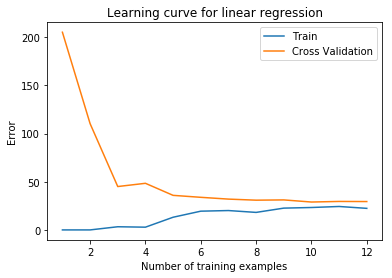

  	1		0.000000	205.121096
  	2		0.000000	110.300366
  	3		3.286595	45.010232
  	4		2.842678	48.368911
  	5		13.154049	35.865141
  	6		19.443963	33.829957
  	7		20.098522	31.970987
  	8		18.172859	30.862446
  	9		22.609405	31.135998
  	10		23.261462	28.936207
  	11		24.317250	29.551432
  	12		22.373906	29.433818


In [39]:
plt.figure()
plt.plot(range(1,m+1),error_train)
plt.plot(range(1,m+1),error_val)
plt.title('Learning curve for linear regression')
plt.legend(['Train', 'Cross Validation'])
plt.xlabel('Number of training examples')
plt.ylabel('Error')
#plt.axis([0, 13, 0, 150])
plt.show()

for i in range(m):
    print('  \t%d\t\t%f\t%f' % (i+1, error_train[i], error_val[i]))

###### As i saw the plots i figured Two Things:
- The Training Error started out small and increased with training samples increasing and the cross validation error started big and decreased untill became very close to the training error 

- The first observation that with increasing the the number of the training samples the model is making higher error and can't predict correctly thus it's underFitting with More Data

- Second Observation the Two lines began to flatten at training example 9 which lead me to know that after adding more training example after training 9 the error is still the same so getting more training data is not gonna help our model

### Poly Features

Now We have diagnosed that Our Data Can't Be Fit with a Linear Model and the Linear Model is underFitting it's to simple for our Data The next step is to make a more complex Model for our Data and we do that by adding Polynomial Features to our data to try and fit a Quadratic Function or a Higher Order Polynomial instead of a Straight Line to Our data

In [40]:
def polyFeatures(X,p):
    X_poly = np.zeros((X.shape[0], p))
    for i in range(p):
        X_poly[:,i] = X[:,0] ** (i+1)
    return X_poly

### Feature Normalization 

It turns out when we add Our Polynomial Features The Features X have a big diffrence gap in Range of the values and the the algorithims fails to minimze our Cost $J(\theta)$ 

So we use a Method Called Feature Normalization to make all our Features range in a certain range of values closer to each other for example $-e<X<e$ where e is real number so we Can Minimze our Function Better 

Mean Normalization Is Used

In [41]:
def featureNormalize(X_poly):
    mu = np.mean(X_poly, axis=0)
    X_norm = X_poly - mu

    sigma = np.std(X_norm, axis=0, ddof=1)
    X_norm /= sigma
    return X_norm, mu, sigma

In [42]:
p = 8 #Poly of Degree 8

# Map X onto Polynomial Features and Normalize
X_poly = polyFeatures(X, p)
X_poly, mu, sigma = featureNormalize(X_poly)
X_poly = np.concatenate([np.ones((m, 1)), X_poly], axis=1)

# Map X_poly_test and normalize (using mu and sigma)
X_poly_test = polyFeatures(Xtest, p)
X_poly_test -= mu
X_poly_test /= sigma
X_poly_test = np.concatenate([np.ones((ytest.size, 1)), X_poly_test], axis=1)

# Map X_poly_val and normalize (using mu and sigma)
X_poly_val = polyFeatures(Xval, p)
X_poly_val -= mu
X_poly_val /= sigma
X_poly_val = np.concatenate([np.ones((yval.size, 1)), X_poly_val], axis=1)

print('Normalized Training Example 1:')
X_poly[0, :]

Normalized Training Example 1:


array([ 1.        , -0.36214078, -0.75508669,  0.18222588, -0.70618991,
        0.30661792, -0.59087767,  0.3445158 , -0.50848117])

### Training Poly LR

The Next Section We Repeat what we did for the Linear Model:
- We train The Model for our Polynomial Features 
- We Plot our Polynomial Function Fit to The Data
- We Plot Learning Cuves for Diagnosis of our New Fit

In [43]:
def plotFit(polyFeatures, min_x, max_x, mu, sigma, theta, p):
    x = np.arange(min_x - 15, max_x + 25, 0.05).reshape(-1, 1)

    # Map the X values
    X_poly = polyFeatures(x, p)
    X_poly -= mu
    X_poly /= sigma

    # Add ones
    X_poly = np.concatenate([np.ones((x.shape[0], 1)), X_poly], axis=1)

    # Plot
    plt.plot(x, np.dot(X_poly, theta), '--', lw=2)

Polynomial Regression (lambda_ = 0.000000)

# Training Examples	Train Error	Cross Validation Error
  	1		0.000000	160.721900
  	2		0.000000	160.121510
  	3		0.000000	61.755005
  	4		0.000000	61.928895
  	5		0.000000	6.597135
  	6		0.000000	10.645052
  	7		0.000000	27.999188
  	8		0.005434	17.855417
  	9		0.013034	20.945219
  	10		0.042793	14.072820
  	11		0.038440	24.971414
  	12		0.094403	8.746484


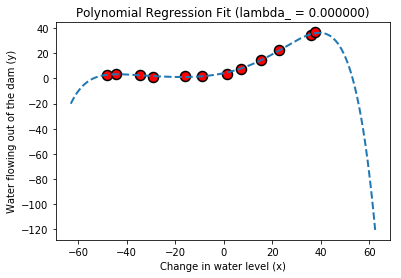

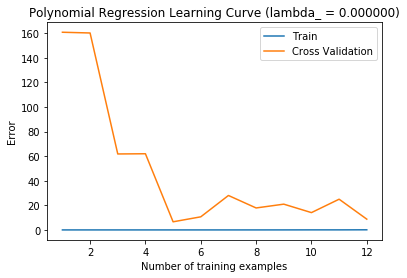

In [44]:
lambda_ = 0
theta = Fit(CostFunction,X_poly, y,lambda_=lambda_,maxiter=55)

# Plot training data and fit
plt.plot(X, y, 'ro', ms=10, mew=1.5, mec='k')

plotFit(polyFeatures, np.min(X), np.max(X), mu, sigma, theta, p)

plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.title('Polynomial Regression Fit (lambda_ = %f)' % lambda_)

plt.figure()
error_train, error_val = LearningCurves(X_poly, y, X_poly_val, yval, lambda_)
plt.plot(np.arange(1, 1+m), error_train, np.arange(1, 1+m), error_val)

plt.title('Polynomial Regression Learning Curve (lambda_ = %f)' % lambda_)
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.legend(['Train', 'Cross Validation'])

print('Polynomial Regression (lambda_ = %f)\n' % lambda_)
print('# Training Examples\tTrain Error\tCross Validation Error')
for i in range(m):
    print('  \t%d\t\t%f\t%f' % (i+1, error_train[i], error_val[i]))

###### After We Saw The Above Plots we See that with C=0:
The First Plot The Polynomial Function is a Perfect Fit for Our Data ?

If We Look at our Learning Curves for the Polynomial Regresssion we see that The Polynomial Fit is doing really good on the training set with Training Error of Zero but it's making a very high erros on the new unseen data of the Cross Validation Set indicating High Variance Problem (OverFitting)

But we see also that the error decreases with increasing the number of training examples so that points us towards an important observation That indeed getting More Training data for This Poly Fit is (Likely To Help) and reduce overfitting and help our model accuracy

### Validation Curves

IF Collecting more training examples is something we can't do there is another Solution to Fix The Model OverFitting Problem and that is Using the Regularization Parameter 

In The Next Section what i do is :
- Make a list of values for Regularization parameter C 
- Train our Model on all of the Training set multiple Times and Each time with a Different Value of C from our list
- Each time the Model is Trained With a Different Value OF C The Train and the Cross Validation Error is Calculated for The Trained Model with that Value of C
- Finally The Validation Curve Plotted is The Follwing on The X Axis we plot Our List of Values OF C and The Y Axis has the Error so our plots measure for Each value of C what Error did the model make on The Training Set and on The Cross Validation Set and Thus Helping US Choose The Value that helped our Model make small Errors in Both 

In [50]:
def validationCurve(X,y,Xval,yval):
    lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
    error_train = np.zeros(len(lambda_vec))
    error_val = np.zeros(len(lambda_vec))
    for i,lambda_ in enumerate(lambda_vec):
        theta = Fit(CostFunction,X,y,lambda_)
        error_train[i],_ = CostFunction(X,y,theta,lambda_=0)
        error_val[i],_ = CostFunction(Xval,yval,theta,lambda_=0)

    return lambda_vec,error_train,error_val

C		Train Error	Validation Error
 0.000000	0.094403	8.746484
 0.001000	0.118469	11.169884
 0.003000	0.170952	16.302371
 0.010000	0.221598	16.965871
 0.030000	0.281843	12.829588
 0.100000	0.459305	7.587301
 0.300000	0.921761	4.636824
 1.000000	2.076188	4.260632
 3.000000	4.901348	3.822899
 10.000000	16.092210	9.945504


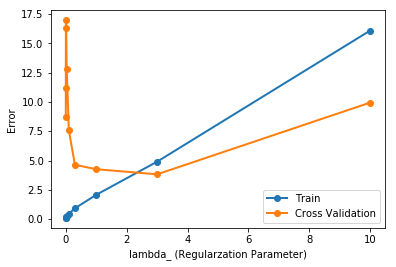

In [51]:
lambda_vec, error_train, error_val = validationCurve(X_poly, y, X_poly_val, yval)

plt.plot(lambda_vec, error_train, '-o', lambda_vec, error_val, '-o', lw=2)
plt.legend(['Train', 'Cross Validation'])
plt.xlabel('lambda_ (Regularzation Parameter)')
plt.ylabel('Error')

print('C\t\tTrain Error\tValidation Error')
for i in range(len(lambda_vec)):
    print(' %f\t%f\t%f' % (lambda_vec[i], error_train[i], error_val[i]))

###### PLOTS OBSERVATIONS
As We Can See From Our Plot that it's a Value Close to 2.2 of C That Does The Best Job at that Values The Two lines Intersect and make Approx The Same Error So That Gives us A Clue What Value To Use On Our Poly Fit 

and Finally we Have Started With a Linear Fit and Using Learning Curves and Validation Curves We managed to Diagnose our Model and Reach A stable Version of It

### Testing The Model

After We Diagnosed The Model We will use the Poly Fit and The Determined Value of C=2.2 and Train the Model and we Will Test our Model on The Test set which the Model never saw during the Prvious Stages

The Prediction of The Test Set is Stored in h will be Plotted Vs The Actual labels ytest

In [52]:
theta = Fit(CostFunction,X_poly,y,2.2,maxiter=55)

In [53]:
h = X_poly_test.dot(theta)

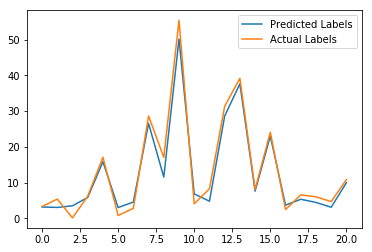

In [54]:
plt.figure()
plt.plot(h,label='Predicted Labels')
plt.plot(ytest,label='Actual Labels')
plt.legend()
plt.show()

###### As We See from The Plot the Predicted Labels is Very Close To the Actual Labels 

That Concludes Our Model Diagnosis We now have a stable Model we Fixed First underFitting Problem and second Fixed OverFitting with Polynomial Features and then we Diagnosed to choose The best Regularization Parameter C to give us a stable Version Finally after Testing Our Model on New Unseen examples Our Model Generalized Very well on Them